# Next semantic embedding prediction with Autoencoders

This notebooks contains a sample implementation of next embedding prediction using an Autoencoder architecture.
- Given a set of N "valid" embeddings, the model will learn to generate the "missing" embedding given N-1 embeddings.
    -  For example the training set could looks like:
```code        
                features           label
            --------------     -----------
example_1, [1,2,3],[3,4,5],...,[m-2,m-1,m]
example_2, [1,2,3],[3,4,5],...,[m-2,m-1,m]
...
example_n, [1,2,3],[3,4,5],...,[m-2,m-1,m]
```
- The model will learn the implicit relation between the embeddings and produce reconstructued outputs in case some parts (embeddings) are missing.
- This concept can be applied to very different settings, but in this example, we apply this idea for implement a basic "Fashion - Complete your look"

![demo](assets/demo.gif)

The notebook contains the examples based on two datases:
 - Small - Using the `Fashion MNIST` dataset
 - Large - Using the `ChictopiaPlus10k` dataset

## 0. Setup

In [19]:
#Run once, for Chictopia dataset, GPU is strongly recommended
!pip install -r requirements.txt
if not os.system("nvidia-smi -L | grep GPU | wc -l"):
    os.system("pip3 install torch torchvision torchaudio") 

In [5]:
import ast
import os
import logging
import cv2
import csv
import glob
import time
import math
import re
import base64
import io
import random
import shutil
from itertools import permutations, product, combinations
from pathlib import Path

import chromadb
import gradio as gr
import pickle
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
import pandas as pd
import torch
from torch import nn
from torch.nn import Linear, Module, MSELoss, ReLU, Sequential, Sigmoid, Dropout
from torch.optim import Adam
from torch.utils.data import DataLoader, Dataset, TensorDataset
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor, functional as F
from vertexai.preview.generative_models import GenerativeModel, Part
from google.cloud import vision, aiplatform
from google.cloud import bigquery
from google.protobuf import struct_pb2
from tqdm import tqdm
# https://github.com/christiansafka/img2vec/tree/master
from img2vec_pytorch import Img2Vec
from matplotlib.pyplot import close, figure, imshow, savefig, show, title
import vertexai

In [6]:
#General settings
PROJECT_ID = "<TO_DO_DEVELOPER>"
LOCATION = "<TO_DO_DEVELOPER>"
#Dataset for logging training data
BQ_DATASET = "fashion_predict"
BQ_TABLE = "train"
TRAIN_FOLDER = "train"
CROPPED_DIR = "cropped"
EMB_FILE_NAME = "emb.csv"
EMBEDDINGS_DIR = "embeddings"
CHROMA_DIR = "chromadb"
INFERENCE_DIR = "inference"
TRAINING_SET_DIR_PREFIX = "training_set_"
VERTEX = "vertex"
LOCAL = "local"
TRAINING_SET_FILE_NAME = "train.csv"
AUGMENTATION_FACTOR = 3
#Change accordingly to the embedding generator being used
MM_EMB_DIMS = 512
DATABASE_FILE = 'emb_kv_database.pkl'
TOP_K = 3

In [7]:
#Fashion MNIST
FASHION_MNIST_IMAGES_DIR = "images_fmnist"
FASHION_MNIST_DATA_DIR = "data"
CATEGORY = "fashion"
LLM = "gemini-pro"
MAX_OBJECTS = 10
LABELS_MAP={
    0: 'T-shirt/top',
    1: 'Trouser',
    2: 'Pullover',
    3: 'Dress',
    4: 'Coat',
    5: 'Sandal',
    6: 'Shirt',
    7: 'Sneaker',
    8: 'Bag',
    9: 'Ankle Boot',
}

In [8]:
#Chictopia Dataset
CHICTOPIA_IMAGES_DIR = "images_chictopia"
ORIGINAL_IMAGE_FORMAT = "_image:png.png"
LABEL_IMAGE_FORMAT = "_label_vis:png.png"
NUM_IMAGES = 23011
#RGB Masks for semantic segmentation
HAT = [255,255,98]
UPPER_CLOTH = [215,68,0]
PANTS = [0,95,213]
SUNGLASSES = [0,214,255]
BAG = [255,44,111]
SKIRT = [0,128,41]
DRESS =  [147,0,104]
BELT = [255,203,181]
LEFT_SHOE = [0,255,197]
RIGHT_SHOE = [167,134,0]
SCARF = [247,255,246]
FASHION_ITEMS = { "HAT" : HAT, 
                 "UPPER_CLOTH" : UPPER_CLOTH, 
                 "PANTS" : PANTS ,
                 "SUNGLASSES" : SUNGLASSES ,
                 "BAG" : BAG ,
                 "SKIRT" : SKIRT ,
                 "DRESS" : DRESS ,
                 "BELT" : BELT ,
                 "LEFT_SHOE" : LEFT_SHOE ,
                 "RIGHT_SHOE" : RIGHT_SHOE ,
                 "SCARF" : SCARF }
CL_WHITE = 255

In [9]:
logging.getLogger().setLevel(logging.INFO)

In [74]:
#Checks GPUs
for i in range(torch.cuda.device_count()):
    properties = torch.cuda.get_device_properties(i)
    logging.info(f"GPU {i}: {properties.name}")
    GPU_INDEX = "0"
dev = torch.device("cuda:"+GPU_INDEX if torch.cuda.is_available() else "cpu")
logging.info(f"Device setup to: {dev}")

INFO:root:Device setup to: cpu


In [19]:
def clear_env():
    if os.path.isdir(CROPPED_DIR):
        logging.info(f"Deleting {CROPPED_DIR}")
        shutil.rmtree(CROPPED_DIR)
    if os.path.isdir(EMBEDDINGS_DIR):
        logging.info(f"Deleting {EMBEDDINGS_DIR}")
        shutil.rmtree(EMBEDDINGS_DIR)
    tr_dir = glob.glob(f"{TRAINING_SET_DIR_PREFIX}*")[0] if  glob.glob(f"{TRAINING_SET_DIR_PREFIX}*") else "na"
    if os.path.isdir(tr_dir):
        logging.info(f"Deleting {tr_dir}")
        shutil.rmtree(tr_dir)
    if os.path.isfile(DATABASE_FILE):
        os.remove(DATABASE_FILE)
    if os.path.isdir(FASHION_MNIST_DATA_DIR):
        logging.info(f"Deleting {FASHION_MNIST_DATA_DIR}")
        shutil.rmtree(FASHION_MNIST_DATA_DIR)
    if os.path.isdir(FASHION_MNIST_IMAGES_DIR):
        logging.info(f"Deleting {FASHION_MNIST_IMAGES_DIR}")
        shutil.rmtree(FASHION_MNIST_IMAGES_DIR)
    if os.path.isdir(CHICTOPIA_IMAGES_DIR):
        logging.info(f"Deleting {CHICTOPIA_IMAGES_DIR}")
        shutil.rmtree(CHICTOPIA_IMAGES_DIR)
    if os.path.isdir(CHROMA_DIR):
        logging.info(f"Deleting {CHROMA_DIR}")
        shutil.rmtree(CHROMA_DIR)       
    logging.info(f"Env cleared")

In [20]:
from ipywidgets import widgets
options_dataset = ["fashion_mnist", "chictopia"]
dropdown = widgets.Dropdown(options=options_dataset) 
dataset = dropdown.value
def on_change(change):
    if change['type'] == 'change' and change['name'] == 'value':
        dataset = change['new']
    
dropdown.observe(on_change)
display(dropdown)

Dropdown(options=('fashion_mnist', 'chictopia'), value='fashion_mnist')

In [21]:
from ipywidgets import widgets
options_engine = ["chroma", "disk"]
dropdown = widgets.Dropdown(options=options_engine) 
engine = dropdown.value
def on_change(change):
    if change['type'] == 'change' and change['name'] == 'value':
        engine = change['new']
    
dropdown.observe(on_change)
display(dropdown)

Dropdown(options=('chroma', 'disk'), value='chroma')

Flags for quick iteration, set True or False to run specific pieces of the notebook

In [22]:
restart_flag = True
preprocess_images_flag_fashion_mnist = True
preprocess_images_chictopia_flag = False
gen_embeddings_flag = True
prepare_training_set_flag = True
launch_train_flag = True
load_saved_model = False
if load_saved_model:
    MODEL_TO_LOAD = "<MODEL_PATH_HERE>" 
    assert os.path.isfile(MODEL_TO_LOAD)
else:    
    MODEL_TO_LOAD = "TRAIN"
lanch_ui_predict = True

In [23]:
#Be careful with, it will wipe out ALL the environment
if restart_flag:
    clear_env()

INFO:root:Deleting cropped
INFO:root:Deleting embeddings
INFO:root:Deleting training_set_20240103-134049
INFO:root:Deleting data
INFO:root:Deleting images_chictopia
INFO:root:Deleting chromadb
INFO:root:Env cleared


## 1. Data preparation

![dataprep](assets/data_prep.png)

### 1.1 Example: Fashion MNIST

- Fashion MNIST, do not provide  full fashion looks but particular garment pictures, so next code will generate random full fashion looks based on simple association rules (for a real world setting move directly to the ChictopiaPlus 10k dataset.

- It can either generate full looks, appending a upper_body + lower_body + footwear or cropped looks

In [26]:
def gen_looks_complete_picture(train_data,num_looks):
    logging.info(f"Generating {num_looks} full looks")
    looks_generated = 0
    IMAGE_FOLDER = "images_fmnist"
    os.makedirs(IMAGE_FOLDER, exist_ok=True)
    allowed_looks = [
        ('T-shirt/top', 'Trouser', 'Sneaker'),
        ('Pullover', 'Trouser', 'Sneaker'),
        ('Shirt', 'Trouser', 'Ankle Boot'),
        ('Coat', 'Trouser', 'sneaker'),
        ('Coat', 'Trouser', 'Ankle Boot'),
        ('Dress', 'Sandal', 'Bag'),
        ('Dress', 'Ankle Boot', 'Bag')]
    while looks_generated < num_looks:
        upper_body_index, lower_body_index, footwear_index = random.sample(range(len(train_data)), 3)
        upper_body_label = LABELS_MAP[train_data[upper_body_index][1]]
        lower_body_label = LABELS_MAP[train_data[lower_body_index][1]]
        footwear_label = LABELS_MAP[train_data[footwear_index][1]]
        if (upper_body_label, lower_body_label, footwear_label) in allowed_looks:
            looks_generated += 1
            upper_body_image, _ = train_data[upper_body_index]
            lower_body_image, _ = train_data[lower_body_index]
            footwear_image, _ = train_data[footwear_index]
            upper_body_np = upper_body_image.squeeze().numpy()
            lower_body_np = lower_body_image.squeeze().numpy()
            footwear_np = footwear_image.squeeze().numpy()
            #Append look
            combined_image = [upper_body_np, lower_body_np, footwear_np]
            plt.figure(figsize=(3, 1))
            plt.subplots_adjust(wspace=0, hspace=0)
            for j, img in enumerate(combined_image, 1):
                plt.subplot(1, 3, j)
                plt.imshow(img, cmap='gray')
                plt.axis('off')
            plt.savefig(os.path.join(IMAGE_FOLDER, f'look_{looks_generated}.png'), bbox_inches='tight')
            plt.close()
            
def gen_looks_cropped(train_data,num_looks):
    logging.info(f"Generating {num_looks} cropped looks")
    looks_generated = 0
    os.makedirs(CROPPED_DIR, exist_ok=True)
    allowed_looks = [
        ('T-shirt/top', 'Trouser', 'Sneaker'),
        ('Pullover', 'Trouser', 'Sneaker'),
        ('Shirt', 'Trouser', 'Ankle Boot'),
        ('Coat', 'Trouser', 'sneaker'),
        ('Coat', 'Trouser', 'Ankle Boot'),
        ('Dress', 'Sandal', 'Bag'),
        ('Dress', 'Ankle Boot', 'Bag')]
    while looks_generated < num_looks:
        upper_body_index, lower_body_index, footwear_index = random.sample(range(len(train_data)), 3)
        upper_body_label = LABELS_MAP[train_data[upper_body_index][1]]
        lower_body_label = LABELS_MAP[train_data[lower_body_index][1]]
        footwear_label = LABELS_MAP[train_data[footwear_index][1]]
        if (upper_body_label, lower_body_label, footwear_label) in allowed_looks:
            os.makedirs(os.path.join(CROPPED_DIR, f'look_{looks_generated}'), exist_ok=True)
            
            upper_body_image, _ = train_data[upper_body_index]
            lower_body_image, _ = train_data[lower_body_index]
            footwear_image, _ = train_data[footwear_index]
            
            save_path_upper = os.path.join(CROPPED_DIR, f'look_{looks_generated}', '0.png')
            save_path_lower = os.path.join(CROPPED_DIR, f'look_{looks_generated}', '1.png')
            save_path_footwear = os.path.join(CROPPED_DIR, f'look_{looks_generated}', '2.png')
            
            plt.imsave(save_path_upper, upper_body_image.squeeze().numpy(), cmap='gray')
            plt.imsave(save_path_lower, lower_body_image.squeeze().numpy(), cmap='gray')
            plt.imsave(save_path_footwear, footwear_image.squeeze().numpy(), cmap='gray')
            looks_generated += 1
            
def get_fashion_mnist(mode="cropped",num_looks=1000):
    train_data= datasets.FashionMNIST(root='data', train=True, download=True, transform=ToTensor(),)
    batch_size = 128
    DataLoader(train_data, batch_size = batch_size)
    if mode == "cropped":
        gen_looks_cropped(train_data,num_looks)
    elif mode == "full":
        gen_looks_complete_picture(train_data,num_looks)
    else:
        logging.info(f"Mode {mode} not suported")            

Next code block is responsible to detect and extract garment items for full looks, particulary interesting its the `_object_belongs_to_category`that uses a LLM to filter fashion items

In [27]:
def _localize_objects(path):
    client = vision.ImageAnnotatorClient()
    with open(path, "rb") as image_file:
        content = image_file.read()
    image = vision.Image(content=content)
    objects = client.object_localization(image=image).localized_object_annotations
    return objects

def _append_id(path,index):
    p = Path(path)
    return "{0}_{2}{1}".format(Path.joinpath(p.parent, p.stem), p.suffix, index)

def _object_belongs_to_category(object_name,category):
    vertexai.init(project=PROJECT_ID, location=LOCATION)
    model = GenerativeModel(LLM)
    #Prevent quota exhasution
    time.sleep(2)
    response = model.generate_content(f"Does the following item belongs to the {category} category?. Item is: {object_name}.Return ONLY True or False", stream=False)
    return eval(response.text)

def _strip_picture(path,objects,category,inference):
    for index,object in enumerate(objects):
        if _object_belongs_to_category(object.name,category) and index < MAX_OBJECTS:
            logging.info(f"{object.name} item detected, stripping ...")
            vertices = object.bounding_poly.normalized_vertices
            cropped_image = _crop_image(path,vertices)
            _save_piece(path,cropped_image,index,inference)
            
def _crop_image(path,vertices):
    image = cv2.imread(path)
    (number_of_rows, number_of_columns) = image.shape[:2]
    x0 = round(vertices[0].x * number_of_columns)
    y0 = round(vertices[0].y * number_of_rows)
    x1 = round(vertices[2].x * number_of_columns)
    y1 = round(vertices[2].y * number_of_rows)
    crop = image[y0:y1, x0:x1]
    return crop
    

def _save_piece(path,img,index,inference):
    filename = Path(path).stem
    if inference:
        directory = os.path.join(CROPPED_DIR,INFERENCE_DIR,filename)
    else:
        directory = os.path.join(CROPPED_DIR,filename)
    Path(directory).mkdir(parents=True, exist_ok=True)
    cv2.imwrite(f"{directory}/{index}.jpg", img)
    logging.info(f"Saved new image to {directory}/{index}.jpg")
    
    
def _extract_items_from_picture(path,category,inference):
    logging.info(f"Category to extract object is set to: {category}")
    objects = _localize_objects(path)
    _strip_picture(path,objects,category,inference)
    

def preprocess_images_fashion_mnist(folder,category,inference=False):
    for image_path in os.listdir(folder):
        if not image_path.startswith('.'):
            _extract_items_from_picture(os.path.join(folder,image_path),category,inference) 

In [28]:
#Setup mode to "cropped" or "full"
mode = "cropped"
num_looks = 256
if preprocess_images_flag_fashion_mnist:
    get_fashion_mnist(mode,num_looks)
    if mode == "full":
        preprocess_images_fashion_mnist(FASHION_MNIST_IMAGES_DIR,CATEGORY)
    logging.info(f"Image preprocess completed")    

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



INFO:root:Generating 256 cropped looks
INFO:root:Image preprocess completed


### 1.2 Example: ChictopiaPlus 10k

Chictopia Dataset is [here](https://files.is.tue.mpg.de/classner/gp/), download it first and place it in a GCS bucket

In [ ]:
os.makedirs(CHICTOPIA_IMAGES_DIR, exist_ok=True)
os.system(f"gcloud storage cp gs://<TO_DO_DEVELOPER>/ChictopiaPlus.zip {CHICTOPIA_IMAGES_DIR}")  
os.system(f"unzip {CHICTOPIA_IMAGES_DIR}/ChictopiaPlus.zip -d {CHICTOPIA_IMAGES_DIR} >/dev/null 2>&1") 

In [ ]:
#Cleaning, we only will process the train folder
shutil.rmtree(os.path.join(CHICTOPIA_IMAGES_DIR,"pose"))
shutil.rmtree(os.path.join(CHICTOPIA_IMAGES_DIR,"test"))
shutil.rmtree(os.path.join(CHICTOPIA_IMAGES_DIR,"val"))
os.system(f"rm {CHICTOPIA_IMAGES_DIR}/train/*_segcolors.png >/dev/null 2>&1")
os.system(f"rm {CHICTOPIA_IMAGES_DIR}/train/*.txt >/dev/null 2>&1")
os.system(f"rm {CHICTOPIA_IMAGES_DIR}/train/*_bodysegments.png >/dev/null 2>&1")
os.system(f"rm {CHICTOPIA_IMAGES_DIR}/train/*_bodysegments_vis.png >/dev/null 2>&1")
os.system(f"rm {CHICTOPIA_IMAGES_DIR}/train/*_labels:png.png >/dev/null 2>&1")

Since the dataset its anotated with a semantic segmentation, we no longer need to use a Object Detection model to extract the garments, we will just "filter" the original image based on the fashion pixel values, then detect the contour of the image and extract the bounding box.

![chictopia](assets/chictopia.png)

In [ ]:
def extract_segment(image_id, target):
    original_image = Image.open(os.path.join(CHICTOPIA_IMAGES_DIR,TRAIN_FOLDER,image_id+ORIGINAL_IMAGE_FORMAT))
    segmentation_image = Image.open(os.path.join(CHICTOPIA_IMAGES_DIR,TRAIN_FOLDER,image_id+LABEL_IMAGE_FORMAT))
    original_array = np.array(original_image)
    segmentation_array = np.array(segmentation_image)
    mask = np.all(segmentation_array == target, axis=-1)
    extracted_portion = original_array.copy()
    extracted_portion[~mask] = [255, 255, 255]  
    result_image = Image.fromarray(extracted_portion)
    return result_image

def crop_object(image,image_id,only_contour=False):
    image_array = np.array(image)
    gray_array = cv2.cvtColor(image_array, cv2.COLOR_BGR2GRAY)
    edges = cv2.Canny(gray_array, 50, 150)
    dilated = cv2.dilate(edges, None, iterations=2)
    eroded = cv2.erode(dilated, None, iterations=1)
    contours, _ = cv2.findContours(eroded, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if contours:
        largest_contour = max(contours, key=cv2.contourArea)
        x, y, w, h = cv2.boundingRect(largest_contour)
        if only_contour:
            cropped_object = image.crop((x, y, x + w, y + h))
        else:
            original_image = Image.open(os.path.join(CHICTOPIA_IMAGES_DIR,TRAIN_FOLDER,image_id+ORIGINAL_IMAGE_FORMAT))
            cropped_object = original_image.crop((x, y, x + w, y + h))
        return cropped_object
    else:
        logging.info('Couldn detect countour')
        return None

def preprocess_images_chictopia(n=NUM_IMAGES):
    for image in tqdm(range(n), desc="Processing images", unit="image"):
        image_id = f"{image:05d}"
        if not os.path.isdir(os.path.join(CROPPED_DIR,image_id)):
            Path(os.path.join(CROPPED_DIR,image_id)).mkdir(parents=True, exist_ok=True)
            for item in FASHION_ITEMS:
                extracted_item = extract_segment(image_id, FASHION_ITEMS[item])
                if not np.all(np.array(extracted_item) == CL_WHITE):
                    cropped_object = crop_object(extracted_item,image_id)
                    if cropped_object:
                        cropped_object.save(os.path.join(CROPPED_DIR,image_id,item.lower()+".png"))
        else:
            logging.info(f"{image_id} already processed")

In [ ]:
if preprocess_images_chictopia_flag:
    preprocess_images_chictopia()

## 2.Training data generation

### 2.1 Embedding generation 

The following code will go over each look, take each piece of fashion and generate a embedding, this can be done either using VertexAI (Multimodal API) or using a pretrained well-know model like ResNet or VGG.
Once each embedding its generated, a subsequent process will aggreagate all emeddings for each look into a CVS file.

In [29]:
def _get_local_embedding(path):
    #logging.info(f"Calculating embedding for {path} using local inference ...")
    #This is a OS package that extract the latest layer of some well know archs. (e.g. Resnet, VGG ..)
    #Im using resnet 18, it ouputs a nice 512 embedding vector
    img_to_vec = Img2Vec(cuda=torch.cuda.is_available(), model ='resnet-18')
    img = Image.open(path).convert("RGB")
    embd_vector =  img_to_vec.get_vec(img, tensor=False)
    return embd_vector.tolist()

def _calculate_emb(path,mode=VERTEX):
    if mode == VERTEX:
        #This will output a larger vector of 1,408 dims
        image = open(path, "rb")
        image_bytes = image.read()
        api_regional_endpoint = "us-central1-aiplatform.googleapis.com"
        client_options = {"api_endpoint": api_regional_endpoint}
        client = aiplatform.gapic.PredictionServiceClient(client_options=client_options)  
        instance = struct_pb2.Struct()
        encoded_content = base64.b64encode(image_bytes).decode("utf-8")
        image_struct = instance.fields['image'].struct_value
        image_struct.fields['bytesBase64Encoded'].string_value = encoded_content
        endpoint = (f"projects/{PROJECT_ID}/locations/{LOCATION}/publishers/google/models/multimodalembedding@001")
        instances = [instance]
        response = client.predict(endpoint=endpoint, instances=instances)
        #Prevent quota exhaustion
        time.sleep(2)
        image_emb_value = response.predictions[0]['imageEmbedding']
        image_embedding = [v for v in image_emb_value]
    elif mode == LOCAL:
        image_embedding = _get_local_embedding(path)
    return image_embedding

    
def _save_emb(emb,image_set,piece,inference):
    if inference:
        directory = os.path.join(EMBEDDINGS_DIR,INFERENCE_DIR,image_set)
    else:
        directory = os.path.join(EMBEDDINGS_DIR,image_set)
    Path(directory).mkdir(parents=True, exist_ok=True)
    with open(os.path.join(directory,EMB_FILE_NAME), "a") as f:
            csvwriter = csv.writer(f, delimiter='|',lineterminator='\n')
            csvwriter.writerow((piece, emb))


def gen_embeddings(folder, inference=False, mode=VERTEX):
    image_sets = [d for d in os.listdir(folder) if not d.startswith('.') and not d.startswith(INFERENCE_DIR)]
    for image_set in tqdm(image_sets, desc="Processing image sets", unit="set"):
        if not os.path.isdir(os.path.join(EMBEDDINGS_DIR,image_set)):
            set_path = os.path.join(folder, image_set)
            for piece in os.listdir(set_path):
                if not piece.startswith('.'):
                    emb = _calculate_emb(os.path.join(set_path, piece), mode)
                    _save_emb(emb, image_set, piece, inference)
       
                            
def postprocess_embeddings_folders(root_dir,threshold):
    for folder_name in os.listdir(root_dir):
        folder_path = os.path.join(root_dir, folder_name)
        if os.path.isdir(folder_path):
            csv_file_path = os.path.join(folder_path, EMB_FILE_NAME)
            if os.path.isfile(csv_file_path):
                with open(csv_file_path, 'r') as csv_file:
                    csv_reader = csv.reader(csv_file)
                    num_lines = sum(1 for _ in csv_reader)
                if num_lines < threshold:
                    logging.info(f"Deleting folder: {folder_path}")
                    shutil.rmtree(folder_path)

In [30]:
#This is the minimun items that a look needs to have to be considered valid
minum_required_items = 3
#Setup to "local" for ResNet etc or "vertex" for multimodal API
embedding_generator = LOCAL
if gen_embeddings_flag:
    gen_embeddings(CROPPED_DIR,False,embedding_generator)
    postprocess_embeddings_folders(EMBEDDINGS_DIR,minum_required_items)

Processing image sets:   0%|          | 0/256 [00:00<?, ?set/s]/opt/conda/envs/pytorch/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/envs/pytorch/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Processing image sets: 100%|██████████| 256/256 [04:18<00:00,  1.01s/set]


### 2.2 Training set post-processing

In [32]:
def prepare_training_set(emb_path):
    training_set_dir = f"{TRAINING_SET_DIR_PREFIX}{time.strftime('%Y%m%d-%H%M%S')}"
    Path(training_set_dir).mkdir(parents=True, exist_ok=True)
    with open(os.path.join(training_set_dir, TRAINING_SET_FILE_NAME), "w") as training_file:
        csvwriter = csv.writer(training_file, delimiter="|",lineterminator='\n')
        for embset in os.listdir(emb_path):
            if not embset.startswith('.') and not  embset.startswith(INFERENCE_DIR):
                vectors_for_id = []
                with open(os.path.join(emb_path, embset, EMB_FILE_NAME), "r") as f:
                    #lineterminator='\n' need for Win
                    reader = csv.reader(f, delimiter="|",lineterminator='\n')
                    for row in reader:
                        for vector_string in row[1:]:
                            vectors_for_id.append(ast.literal_eval(vector_string))
                csvwriter.writerow([embset] + vectors_for_id)
    return training_set_dir     

In [33]:
def get_max_items(folder, items_threshold):
    max_count = 0
    for folder_name in os.listdir(folder):
        folder_path = os.path.join(folder, folder_name)
        if os.path.isdir(folder_path):
            count = len(glob.glob(os.path.join(folder_path, '*.png')))
            if count < items_threshold:
                logging.info(f"Deleting {folder_path} with {count} items")
                shutil.rmtree(folder_path)
            if count > max_count:
                max_count = count
    logging.info(f"Max items is {max_count}")
    return max_count

In [34]:
if prepare_training_set_flag:
    training_set_dir = prepare_training_set(EMBEDDINGS_DIR)
else:
    training_set_dir = os.path.normpath(max((os.path.join('.', d) for d in os.listdir('.') if d.startswith(TRAINING_SET_DIR_PREFIX) and os.path.isdir(os.path.join('.', d))), key=os.path.getmtime, default=None))
items_threshold = 3
MAX_ITEMS = get_max_items(CROPPED_DIR,3)    

INFO:root:Max items is 3


At this point, you should have the `training_set_%Y%m%d-%H%M%S/train.csv`similar to
![train](assets/train.png)

## 3. Catalog  generation

The following code will generate a catalog of items, it will be the basis for seaching similar items on the prediction phase. It supports a very basic disk mode, or a recommended database approach using chromadb

In [35]:
def gen_catalog_emb_space(cropped, mode, engine,collection=None):
    emb_space = {}
    look_folders = [d for d in os.listdir(cropped) if not d.startswith('.') and not d.startswith(INFERENCE_DIR)]
    
    for look_folder in tqdm(look_folders, desc="Processing look folders", unit="folder"):
        folder_path = os.path.join(cropped, look_folder)
        for item in os.listdir(folder_path):
            if not item.startswith('.'):
                emb = _calculate_emb(os.path.join(folder_path, item), mode)
                if engine == 'disk':
                    emb_space[f"{look_folder}-{item}"] = torch.tensor(emb)
                elif engine == 'chromadb':
                        collection.add(ids=f"{look_folder}-{item}",embeddings=emb)
                else:
                    logging.info(f"{engine} engine not supported")
    return emb_space

def _cosine_similarity(a, b,dev):
    a_dev = a.to(dev)
    b_dev = b.to(dev)
    dot_product = torch.sum(a_dev * b_dev)
    norm_a = torch.norm(a)
    norm_b = torch.norm(b)
    similarity = dot_product / (norm_a * norm_b)
    return similarity.item()

def search_closest(inference_input,emb_kv_database,top_k,dev,engine):
    if engine == 'disk':
        similarities = []
        for key, emb in emb_kv_database.items():
            
            similarity = _cosine_similarity(inference_input, emb,dev)
            similarities.append((key, similarity))

        similarities.sort(key=lambda x: x[1], reverse=True)
        top_similarities = similarities[:top_k]
    elif engine == 'chromadb':
        top_similarities =  emb_kv_database.query(query_embeddings=inference_input.tolist(),n_results=top_k)
    else:
        logging.info(f"{engine} engine not supported")
        top_similarities = []   
    return top_similarities


def gen_emb_kv_database(engine):
    if engine == 'disk':
        if os.path.isfile(DATABASE_FILE):
            with open(DATABASE_FILE, 'rb') as database:
                emb_kv_database = pickle.load(database)
                logging.info('Database restored successfully from file')
        else:    
            emb_kv_database = gen_catalog_emb_space(CROPPED_DIR,LOCAL,engine)
            with open(DATABASE_FILE, 'wb') as database:
                pickle.dump(emb_kv_database, database)
                logging.info('Database saved successfully to file')
    elif engine == 'chromadb':
        client = chromadb.PersistentClient(path=CHROMA_DIR)
        collection = client.get_or_create_collection(name="catalog")
        if  collection.count() == 0:
            logging.info('Creating collection from scratch')
            gen_catalog_emb_space(CROPPED_DIR,LOCAL,engine,collection)
        emb_kv_database = collection
    else:
        logging.info(f"{engine} engine not supported")
        emb_kv_database = None
    return emb_kv_database

In [36]:
emb_kv_database = gen_emb_kv_database("chromadb")

INFO:chromadb.telemetry.product.posthog:Anonymized telemetry enabled. See                     https://docs.trychroma.com/telemetry for more information.
INFO:root:Creating collection from scratch
Processing look folders: 100%|██████████| 256/256 [04:26<00:00,  1.04s/folder]


In [41]:
emb_kv_database.peek(1)

{'ids': ['look_0-0.png'],
 'embeddings': [[3.0192980766296387,
   0.1455582082271576,
   0.5191938877105713,
   0.5461011528968811,
   0.00864288117736578,
   0.5225144028663635,
   0.4167744517326355,
   0.2556920349597931,
   1.6224051713943481,
   0.29903748631477356,
   0.16156911849975586,
   0.7393051385879517,
   0.7094406485557556,
   0.03257123380899429,
   0.50879967212677,
   1.9513459205627441,
   0.0,
   0.04378326237201691,
   1.5726767778396606,
   0.2576442062854767,
   1.3726520538330078,
   0.041179168969392776,
   1.105421781539917,
   0.0,
   0.006202642805874348,
   0.23322440683841705,
   0.19525045156478882,
   1.5565983057022095,
   1.7543985843658447,
   0.27565041184425354,
   1.1467911005020142,
   1.0388020277023315,
   0.43032440543174744,
   0.8517464399337769,
   1.7820963859558105,
   0.7155877947807312,
   0.08149772882461548,
   1.9268016815185547,
   1.4559032917022705,
   0.1765507161617279,
   1.2365375757217407,
   0.043951116502285004,
   0.0,
   

## 4. Model training

### 4.1 Data Loaders

Folowing code define the Pytorch dataset and dataloaders.

In order for the model to learn the embeddings associations independetly of the position  we are placing it on the training set (e.g. do not always predict footwear), we need to permute the data. Calculate all the possible permutations of `MAX_ITEM`can be q quite heavy process, for instance for Chictopia, this vlaue is set to 9, so we optimize the number of permutations based on the index of the first tensor with valid value for the sparse examples. Normally a full look contais around 4 or 5 items.

In [37]:
def _find_first_zero_row(tensor):
    m, n = tensor.shape
    for i in range(m):
        if torch.all(tensor[i] == 0):
            return i 
    return m

def augment_data(data,n):
    augmented_data = []
    for tensor in data:
        if not n:
            n = _find_first_zero_row(tensor)
        indices = list(range(n))
        indices_permutations = list(permutations(indices))
        for perm in indices_permutations:
            augmented_tensor = torch.zeros_like(tensor)
            for i in range(n):
                augmented_tensor[i] = tensor[perm[i]]
            augmented_data.append(augmented_tensor)
    return augmented_data

In [38]:
def _load_training_data_autoencoder(filepath,augmentation=False,augmentation_permutations=None,bigquery_log=False):
    completed_looks = []
    with open(filepath, "r") as f:
        reader = csv.reader(f, delimiter='|')
        total_rows = sum(1 for _ in reader)  
        f.seek(0) 
        for row in tqdm(reader, total=total_rows, desc="Loading Data", unit="row"):
            vectors = row[1:]
            vectors = [ast.literal_eval(vector) for vector in vectors]
            vectors = vectors[:MAX_ITEMS]
            missing_vectors = [0] * (MAX_ITEMS - len(vectors))
            for i in range(len(missing_vectors)):
                missing_vectors[i] = [0] * MM_EMB_DIMS
            vectors.extend(missing_vectors)
            torch_vectors = torch.tensor(vectors, dtype=torch.float32)
            completed_looks.append(torch_vectors)
            
        if augmentation:
            logging.info(f"Augmenting data with {augmentation_permutations} permutations..")
            completed_looks = completed_looks + augment_data(completed_looks,augmentation_permutations)
    if not bigquery_log:
        return completed_looks
    else:
        client = bigquery.Client()
        dataset_options = bigquery.Dataset(f"{PROJECT_ID}.{BQ_DATASET}")
        dataset = client.create_dataset(dataset_options, exists_ok=True)
        table_ref = client.dataset(BQ_DATASET).table(Path(filepath).parent.as_posix())
        schema = [bigquery.SchemaField(f'feature_vector_{i}', 'FLOAT', mode='REPEATED') for i in range(MAX_ITEMS)]
        job_config = bigquery.LoadJobConfig(schema=schema,write_disposition="WRITE_TRUNCATE")
        records = []
        for record in completed_looks:
            row = {f"feature_vector_{i}" : record[i].tolist() for i in range(MAX_ITEMS)}
            records.append(row)
        job = client.load_table_from_json(records, table_ref, job_config=job_config)
        job.result()
        logging.info(f"Table {Path(filepath).parent.as_posix()} generated in BigQuery")
        return completed_looks

In [65]:
class LooksDataset(Dataset):
    def __init__(self, data_list, items_to_predict):
        self.data_list = data_list
        self.items_to_predict = items_to_predict
        assert items_to_predict >= 2
        
    def __len__(self):
        return len(self.data_list)

    def __getitem__(self, idx):
        item = self.data_list[idx]
        n = min(self.items_to_predict, len(item) - 1)
        data = item[:n]
        label = item[n]      
        return {'data': data, 'label': label}

I have added this extremely inefficient DataLoader for BQ tables, it works, but obviuosly need further work

In [25]:
class ExperimentalLooksDatasetBigQuery(Dataset):
    def __init__(self, project_id, dataset_id, table_id, items_to_predict,chunk_size=1000):
        self.project_id = project_id
        self.dataset_id = dataset_id
        self.table_id = table_id
        self.chunk_size = chunk_size
        self.client = bigquery.Client()
        self.query = f"SELECT * FROM `{project_id}.{dataset_id}.{table_id}`"
        self.indices = list(range(0, self.get_dataset_size(), self.chunk_size))
        self.items_to_predict = items_to_predict
        assert items_to_predict >= 2

    def get_dataset_size(self):
        query_job = self.client.query(f"SELECT COUNT(*) as total_rows FROM `{self.project_id}.{self.dataset_id}.{self.table_id}`")
        logging.info(f"SELECT COUNT(*) as total_rows FROM `{self.project_id}.{self.dataset_id}.{self.table_id}`")
        result = query_job.result()
        total_rows = list(result)[0]['total_rows']
        return total_rows

    def fetch_data(self, start_index):
        query = f"{self.query} LIMIT {self.chunk_size} OFFSET {start_index}"
        query_job = self.client.query(query)
        result = query_job.result()
        data = [dict(row.items()) for row in result]
        return data

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        start_index = self.indices[idx]
        
        data_chunk = self.fetch_data(start_index)
        n = min(self.items_to_predict, len(data_chunk) - 1)
        data = []
        labels = []

        for entry in data_chunk:
            feature_vectors = [entry[f'feature_vector_{i}'] for i in range(len(entry) - 1)]
            label = entry[f'feature_vector_{len(entry) - 1}']
            data.append(feature_vectors)
            labels.append(label)
        return {'data': torch.tensor(data), 'label': torch.tensor(labels)}

In [26]:
#looks_ds = ExperimentalLooksDatasetBigQuery(project_id=PROJECT_ID,dataset_id=BQ_DATASET,table_id=training_set_dir,items_to_predict=3,chunk_size=BATCH_SIZE)
#train_loader = DataLoader(looks_ds, batch_size=1, shuffle=True)

In [43]:
bigquery_log = False
#augmentation_permutations = None, for dynamic permutation calculation based on the sparsity of  the tensor (e.g. do not permute tensors after first all-zero tensor)
training_mem_set = filepath=os.path.join(training_set_dir,TRAINING_SET_FILE_NAME)
training_data = _load_training_data_autoencoder(training_mem_set,augmentation=True,augmentation_permutations=None, bigquery_log=bigquery_log)

Loading Data: 100%|██████████| 256/256 [00:01<00:00, 135.93row/s]
INFO:root:Augmenting data with None permutations..


In [66]:
#Items to predict = given items_to_predict-1, predict items_to_predict (e.g. if items_to_predict=3, given 2 items predict the third one)
BATCH_SIZE = 32
looks_ds = LooksDataset(data_list=training_data,items_to_predict=3)
train_loader = DataLoader(looks_ds, batch_size=BATCH_SIZE, shuffle=True)

### 4.2 Model definition

In [45]:
encoder_layer_sizes = [2*MM_EMB_DIMS,512,256,128,64,32,16,8]
decode_layer_sizes = []                           
lr = 0.001                        
epochs = 100

Autoencoder model definition is taken from [this](https://www.kaggle.com/code/weka511/autoencoder-implementation-in-pytorch) nice implementation. Ive added a few things like Dropouts and dimension adjustment

In [46]:
class AutoEncoder(Module):
    @staticmethod
    def get_non_linearity(params):
        def get_one(param):
            param = param.lower()
            if param=='relu': return ReLU()
            if param=='sigmoid': return Sigmoid()
            return None
        decoder_non_linearity = get_one(params[0])
        encoder_non_linearity = getnl(params[a]) if len(params)>1 else decoder_non_linearity
        return encoder_non_linearity,decoder_non_linearity

    @staticmethod
    def build_layer(sizes,non_linearity = None, dropout = False):
        linears = []
        for m,n in zip(sizes[:-1],sizes[1:]):
            linears.append(Linear(m,n))
            if dropout:
                linears.append(Dropout(0.2))
        if non_linearity==None:
            return Sequential(*linears)
        else:
            layers = Sequential(*[item for pair in [(layer,non_linearity) for layer in linears] for item in pair])
            return layers

    def __init__(self,
                 encoder_sizes         = [2*MM_EMB_DIMS,400,200,100,50,25,6],
                 encoder_non_linearity = ReLU(inplace=True),
                 decoder_sizes         = [],
                 decoder_non_linearity = ReLU(inplace=True)):
        super().__init__()
        self.encoder_sizes = encoder_sizes
        self.decoder_sizes = encoder_sizes[::-1] if len(decoder_sizes)==0 else decoder_sizes
        #Decoder should project only on the MM_EMB_DIMS. 1 garment
        self.decoder_sizes[-1] = MM_EMB_DIMS
        self.encoder = AutoEncoder.build_layer(self.encoder_sizes,non_linearity = encoder_non_linearity)
        self.decoder = AutoEncoder.build_layer(self.decoder_sizes,non_linearity = decoder_non_linearity)
        self.encode  = True
        self.decode  = True

    def forward(self, x):
        if self.encode:
            x = self.encoder(x)
        if self.decode:
            x = self.decoder(x)
        return x

    def n_encoded(self):
        return self.encoder_sizes[-1]

### 4.3 Training loop

In [47]:
def train(loader,model,optimizer,criterion,epochs = 25,dev = 'cpu'):
    losses = []
    for epoch in range(epochs):
        epoch_loss = 0
        with tqdm(loader, desc=f"Epoch {epoch + 1}/{epochs}", unit="batch") as t:
            for item in t:
                data = item['data']
                label = item['label'].to(dev)
                # Flatten look, from (2, MM_EMB_DIMS) to 2*MM_EMB_DIMS
                data_flattened = data.view(-1, 2 * MM_EMB_DIMS).to(dev)
                optimizer.zero_grad()
                outputs = model(data_flattened)
                #label = torch.unsqueeze(label, dim=0).to(dev)
                train_loss = criterion(outputs, label)
                train_loss.backward()
                optimizer.step()
                epoch_loss += train_loss.item()
                t.set_postfix(loss=epoch_loss / (t.n + 1)) 
            losses.append(epoch_loss / len(loader))
            print(f'Epoch {epoch + 1}/{epochs}, Average Loss: {losses[-1]:.6f}')
    return losses

In [48]:
def launch_train():
    dev = torch.device("cuda:"+str(GPU_INDEX) if torch.cuda.is_available() else "cpu")
    encoder_non_linearity,decoder_non_linearity = AutoEncoder.get_non_linearity(['relu'])
    model = AutoEncoder(encoder_sizes = encoder_layer_sizes,encoder_non_linearity = encoder_non_linearity,decoder_non_linearity = decoder_non_linearity,decoder_sizes = decode_layer_sizes).to(dev)
    if os.path.isfile(MODEL_TO_LOAD):
        model.load_state_dict(torch.load(MODEL_TO_LOAD,map_location=torch.device('cpu')))
        logging.info(f"Model {MODEL_TO_LOAD}  loaded!")
    optimizer = torch.optim.Adam(model.parameters(),lr = lr)
    criterion = MSELoss()
    if not os.path.isfile(MODEL_TO_LOAD):
        losses = train(train_loader,model,optimizer,criterion,epochs=epochs,dev=dev)
    else:
        logging.info("Model already loaded!")
        losses = []
    return model,losses

In [49]:
def plot_losses(losses,lr= 0.001,encoder= [],decoder = [],epochs= 25,show = False,figs = './figs',prefix= 'ae',test_loss= 0):
    fig = figure(figsize=(10,10))
    ax  = fig.subplots()
    ax.plot(losses)
    ax.set_ylim(bottom=0)
    ax.set_title(f'Training Losses after {epochs} epochs')
    ax.set_ylabel('MSELoss')
    ax.text(0.95, 0.95, '\n'.join([f'lr = {lr}',f'encoder = {encoder}',f'decoder = {decoder}',f'test loss = {test_loss:.3f}']),
    transform = ax.transAxes,
    fontsize  = 14,
    verticalalignment = 'top',
    horizontalalignment = 'right',
    bbox = dict(boxstyle  = 'round',facecolor = 'wheat',alpha = 0.5))
    savefig(os.path.join(figs,f'{prefix}-losses'))
    if not show:
        close(fig)

Epoch 1/100: 100%|██████████| 56/56 [00:01<00:00, 39.35batch/s, loss=0.836]


Epoch 1/100, Average Loss: 0.835552


Epoch 2/100: 100%|██████████| 56/56 [00:01<00:00, 42.95batch/s, loss=0.661]


Epoch 2/100, Average Loss: 0.660855


Epoch 3/100: 100%|██████████| 56/56 [00:01<00:00, 42.51batch/s, loss=0.66] 


Epoch 3/100, Average Loss: 0.659961


Epoch 4/100: 100%|██████████| 56/56 [00:01<00:00, 41.92batch/s, loss=0.655]


Epoch 4/100, Average Loss: 0.654944


Epoch 5/100: 100%|██████████| 56/56 [00:01<00:00, 39.07batch/s, loss=0.69] 


Epoch 5/100, Average Loss: 0.653247


Epoch 6/100: 100%|██████████| 56/56 [00:01<00:00, 36.05batch/s, loss=0.648]


Epoch 6/100, Average Loss: 0.613259


Epoch 7/100: 100%|██████████| 56/56 [00:01<00:00, 34.28batch/s, loss=0.544]


Epoch 7/100, Average Loss: 0.544282


Epoch 8/100: 100%|██████████| 56/56 [00:02<00:00, 25.22batch/s, loss=0.56] 


Epoch 8/100, Average Loss: 0.539639


Epoch 9/100: 100%|██████████| 56/56 [00:02<00:00, 25.01batch/s, loss=0.546]


Epoch 9/100, Average Loss: 0.536649


Epoch 10/100: 100%|██████████| 56/56 [00:01<00:00, 39.38batch/s, loss=0.551]


Epoch 10/100, Average Loss: 0.530942


Epoch 11/100: 100%|██████████| 56/56 [00:01<00:00, 32.77batch/s, loss=0.541]


Epoch 11/100, Average Loss: 0.511774


Epoch 12/100: 100%|██████████| 56/56 [00:01<00:00, 28.64batch/s, loss=0.516]


Epoch 12/100, Average Loss: 0.497160


Epoch 13/100: 100%|██████████| 56/56 [00:02<00:00, 25.96batch/s, loss=0.497]


Epoch 13/100, Average Loss: 0.488581


Epoch 14/100: 100%|██████████| 56/56 [00:02<00:00, 22.92batch/s, loss=0.483]


Epoch 14/100, Average Loss: 0.483103


Epoch 15/100: 100%|██████████| 56/56 [00:02<00:00, 26.56batch/s, loss=0.47] 


Epoch 15/100, Average Loss: 0.461842


Epoch 16/100: 100%|██████████| 56/56 [00:01<00:00, 29.77batch/s, loss=0.469]


Epoch 16/100, Average Loss: 0.451867


Epoch 17/100: 100%|██████████| 56/56 [00:01<00:00, 28.08batch/s, loss=0.448]


Epoch 17/100, Average Loss: 0.440264


Epoch 18/100: 100%|██████████| 56/56 [00:02<00:00, 26.95batch/s, loss=0.441]


Epoch 18/100, Average Loss: 0.433331


Epoch 19/100: 100%|██████████| 56/56 [00:02<00:00, 26.60batch/s, loss=0.436]


Epoch 19/100, Average Loss: 0.428650


Epoch 20/100: 100%|██████████| 56/56 [00:02<00:00, 27.23batch/s, loss=0.428]


Epoch 20/100, Average Loss: 0.420226


Epoch 21/100: 100%|██████████| 56/56 [00:02<00:00, 27.70batch/s, loss=0.424]


Epoch 21/100, Average Loss: 0.416028


Epoch 22/100: 100%|██████████| 56/56 [00:02<00:00, 27.23batch/s, loss=0.42] 


Epoch 22/100, Average Loss: 0.412610


Epoch 23/100: 100%|██████████| 56/56 [00:02<00:00, 26.10batch/s, loss=0.42] 


Epoch 23/100, Average Loss: 0.412046


Epoch 24/100: 100%|██████████| 56/56 [00:02<00:00, 25.92batch/s, loss=0.415]


Epoch 24/100, Average Loss: 0.407365


Epoch 25/100: 100%|██████████| 56/56 [00:02<00:00, 25.91batch/s, loss=0.412]


Epoch 25/100, Average Loss: 0.405065


Epoch 26/100: 100%|██████████| 56/56 [00:02<00:00, 25.99batch/s, loss=0.411]


Epoch 26/100, Average Loss: 0.403535


Epoch 27/100: 100%|██████████| 56/56 [00:02<00:00, 26.58batch/s, loss=0.409]


Epoch 27/100, Average Loss: 0.401993


Epoch 28/100: 100%|██████████| 56/56 [00:02<00:00, 26.43batch/s, loss=0.404]


Epoch 28/100, Average Loss: 0.404136


Epoch 29/100: 100%|██████████| 56/56 [00:02<00:00, 19.60batch/s, loss=0.4]  


Epoch 29/100, Average Loss: 0.400414


Epoch 30/100: 100%|██████████| 56/56 [00:03<00:00, 17.76batch/s, loss=0.437]


Epoch 30/100, Average Loss: 0.421616


Epoch 31/100: 100%|██████████| 56/56 [00:02<00:00, 26.19batch/s, loss=0.404]


Epoch 31/100, Average Loss: 0.396887


Epoch 32/100: 100%|██████████| 56/56 [00:02<00:00, 26.74batch/s, loss=0.419]


Epoch 32/100, Average Loss: 0.411940


Epoch 33/100: 100%|██████████| 56/56 [00:02<00:00, 26.16batch/s, loss=0.396]


Epoch 33/100, Average Loss: 0.388955


Epoch 34/100: 100%|██████████| 56/56 [00:02<00:00, 26.19batch/s, loss=0.393]


Epoch 34/100, Average Loss: 0.386000


Epoch 35/100: 100%|██████████| 56/56 [00:02<00:00, 19.10batch/s, loss=0.383]


Epoch 35/100, Average Loss: 0.382623


Epoch 36/100: 100%|██████████| 56/56 [00:02<00:00, 19.55batch/s, loss=0.388]


Epoch 36/100, Average Loss: 0.381231


Epoch 37/100: 100%|██████████| 56/56 [00:02<00:00, 25.94batch/s, loss=0.388]


Epoch 37/100, Average Loss: 0.381383


Epoch 38/100: 100%|██████████| 56/56 [00:02<00:00, 25.93batch/s, loss=0.387]


Epoch 38/100, Average Loss: 0.379645


Epoch 39/100: 100%|██████████| 56/56 [00:02<00:00, 26.09batch/s, loss=0.385]


Epoch 39/100, Average Loss: 0.377968


Epoch 40/100: 100%|██████████| 56/56 [00:02<00:00, 24.47batch/s, loss=0.381]


Epoch 40/100, Average Loss: 0.374534


Epoch 41/100: 100%|██████████| 56/56 [00:02<00:00, 24.89batch/s, loss=0.378]


Epoch 41/100, Average Loss: 0.377721


Epoch 42/100: 100%|██████████| 56/56 [00:02<00:00, 25.42batch/s, loss=0.385]


Epoch 42/100, Average Loss: 0.377678


Epoch 43/100: 100%|██████████| 56/56 [00:02<00:00, 22.11batch/s, loss=0.373]


Epoch 43/100, Average Loss: 0.372517


Epoch 44/100: 100%|██████████| 56/56 [00:02<00:00, 23.86batch/s, loss=0.38] 


Epoch 44/100, Average Loss: 0.373073


Epoch 45/100: 100%|██████████| 56/56 [00:02<00:00, 25.59batch/s, loss=0.379]


Epoch 45/100, Average Loss: 0.371995


Epoch 46/100: 100%|██████████| 56/56 [00:02<00:00, 25.64batch/s, loss=0.377]


Epoch 46/100, Average Loss: 0.370352


Epoch 47/100: 100%|██████████| 56/56 [00:02<00:00, 25.16batch/s, loss=0.376]


Epoch 47/100, Average Loss: 0.369668


Epoch 48/100: 100%|██████████| 56/56 [00:02<00:00, 25.82batch/s, loss=0.375]


Epoch 48/100, Average Loss: 0.368261


Epoch 49/100: 100%|██████████| 56/56 [00:02<00:00, 26.38batch/s, loss=0.376]


Epoch 49/100, Average Loss: 0.369196


Epoch 50/100: 100%|██████████| 56/56 [00:02<00:00, 26.80batch/s, loss=0.378]


Epoch 50/100, Average Loss: 0.371099


Epoch 51/100: 100%|██████████| 56/56 [00:02<00:00, 26.15batch/s, loss=0.374]


Epoch 51/100, Average Loss: 0.367253


Epoch 52/100: 100%|██████████| 56/56 [00:02<00:00, 25.74batch/s, loss=0.374]


Epoch 52/100, Average Loss: 0.367701


Epoch 53/100: 100%|██████████| 56/56 [00:02<00:00, 25.46batch/s, loss=0.373]


Epoch 53/100, Average Loss: 0.366670


Epoch 54/100: 100%|██████████| 56/56 [00:02<00:00, 25.48batch/s, loss=0.37] 


Epoch 54/100, Average Loss: 0.363806


Epoch 55/100: 100%|██████████| 56/56 [00:02<00:00, 25.47batch/s, loss=0.37] 


Epoch 55/100, Average Loss: 0.363289


Epoch 56/100: 100%|██████████| 56/56 [00:02<00:00, 25.77batch/s, loss=0.369]


Epoch 56/100, Average Loss: 0.361927


Epoch 57/100: 100%|██████████| 56/56 [00:02<00:00, 25.72batch/s, loss=0.365]


Epoch 57/100, Average Loss: 0.358400


Epoch 58/100: 100%|██████████| 56/56 [00:03<00:00, 14.25batch/s, loss=0.371]


Epoch 58/100, Average Loss: 0.358049


Epoch 59/100: 100%|██████████| 56/56 [00:02<00:00, 25.60batch/s, loss=0.363]


Epoch 59/100, Average Loss: 0.356988


Epoch 60/100: 100%|██████████| 56/56 [00:02<00:00, 25.31batch/s, loss=0.367]


Epoch 60/100, Average Loss: 0.360069


Epoch 61/100: 100%|██████████| 56/56 [00:02<00:00, 18.84batch/s, loss=0.362]


Epoch 61/100, Average Loss: 0.361957


Epoch 62/100: 100%|██████████| 56/56 [00:02<00:00, 18.98batch/s, loss=0.354]


Epoch 62/100, Average Loss: 0.354124


Epoch 63/100: 100%|██████████| 56/56 [00:02<00:00, 25.75batch/s, loss=0.361]


Epoch 63/100, Average Loss: 0.354718


Epoch 64/100: 100%|██████████| 56/56 [00:02<00:00, 25.99batch/s, loss=0.364]


Epoch 64/100, Average Loss: 0.357524


Epoch 65/100: 100%|██████████| 56/56 [00:02<00:00, 25.64batch/s, loss=0.358]


Epoch 65/100, Average Loss: 0.351403


Epoch 66/100: 100%|██████████| 56/56 [00:02<00:00, 25.91batch/s, loss=0.364]


Epoch 66/100, Average Loss: 0.350959


Epoch 67/100: 100%|██████████| 56/56 [00:02<00:00, 25.67batch/s, loss=0.357]


Epoch 67/100, Average Loss: 0.350895


Epoch 68/100: 100%|██████████| 56/56 [00:02<00:00, 25.51batch/s, loss=0.356]


Epoch 68/100, Average Loss: 0.349324


Epoch 69/100: 100%|██████████| 56/56 [00:02<00:00, 26.10batch/s, loss=0.352]


Epoch 69/100, Average Loss: 0.346194


Epoch 70/100: 100%|██████████| 56/56 [00:02<00:00, 26.24batch/s, loss=0.356]


Epoch 70/100, Average Loss: 0.349292


Epoch 71/100: 100%|██████████| 56/56 [00:02<00:00, 23.22batch/s, loss=0.357]


Epoch 71/100, Average Loss: 0.350364


Epoch 72/100: 100%|██████████| 56/56 [00:02<00:00, 22.45batch/s, loss=0.353]


Epoch 72/100, Average Loss: 0.340315


Epoch 73/100: 100%|██████████| 56/56 [00:02<00:00, 25.51batch/s, loss=0.344]


Epoch 73/100, Average Loss: 0.338041


Epoch 74/100: 100%|██████████| 56/56 [00:02<00:00, 25.65batch/s, loss=0.341]


Epoch 74/100, Average Loss: 0.335301


Epoch 75/100: 100%|██████████| 56/56 [00:02<00:00, 25.67batch/s, loss=0.337]


Epoch 75/100, Average Loss: 0.331020


Epoch 76/100: 100%|██████████| 56/56 [00:02<00:00, 25.59batch/s, loss=0.335]


Epoch 76/100, Average Loss: 0.328668


Epoch 77/100: 100%|██████████| 56/56 [00:02<00:00, 25.96batch/s, loss=0.335]


Epoch 77/100, Average Loss: 0.328983


Epoch 78/100: 100%|██████████| 56/56 [00:02<00:00, 26.11batch/s, loss=0.338]


Epoch 78/100, Average Loss: 0.331515


Epoch 79/100: 100%|██████████| 56/56 [00:02<00:00, 25.58batch/s, loss=0.332]


Epoch 79/100, Average Loss: 0.325714


Epoch 80/100: 100%|██████████| 56/56 [00:02<00:00, 23.87batch/s, loss=0.323]


Epoch 80/100, Average Loss: 0.323230


Epoch 81/100: 100%|██████████| 56/56 [00:02<00:00, 25.86batch/s, loss=0.337]


Epoch 81/100, Average Loss: 0.330659


Epoch 82/100: 100%|██████████| 56/56 [00:02<00:00, 25.18batch/s, loss=0.333]


Epoch 82/100, Average Loss: 0.327288


Epoch 83/100: 100%|██████████| 56/56 [00:02<00:00, 25.36batch/s, loss=0.326]


Epoch 83/100, Average Loss: 0.320556


Epoch 84/100: 100%|██████████| 56/56 [00:02<00:00, 26.23batch/s, loss=0.321]


Epoch 84/100, Average Loss: 0.315657


Epoch 85/100: 100%|██████████| 56/56 [00:02<00:00, 26.00batch/s, loss=0.322]


Epoch 85/100, Average Loss: 0.315774


Epoch 86/100: 100%|██████████| 56/56 [00:03<00:00, 14.03batch/s, loss=0.323]


Epoch 86/100, Average Loss: 0.317501


Epoch 87/100: 100%|██████████| 56/56 [00:03<00:00, 16.96batch/s, loss=0.339]


Epoch 87/100, Average Loss: 0.338517


Epoch 88/100: 100%|██████████| 56/56 [00:02<00:00, 22.09batch/s, loss=0.324]


Epoch 88/100, Average Loss: 0.318656


Epoch 89/100: 100%|██████████| 56/56 [00:02<00:00, 26.07batch/s, loss=0.322]


Epoch 89/100, Average Loss: 0.315977


Epoch 90/100: 100%|██████████| 56/56 [00:02<00:00, 26.03batch/s, loss=0.319]


Epoch 90/100, Average Loss: 0.313633


Epoch 91/100: 100%|██████████| 56/56 [00:02<00:00, 25.71batch/s, loss=0.317]


Epoch 91/100, Average Loss: 0.311230


Epoch 92/100: 100%|██████████| 56/56 [00:02<00:00, 25.96batch/s, loss=0.323]


Epoch 92/100, Average Loss: 0.311023


Epoch 93/100: 100%|██████████| 56/56 [00:02<00:00, 25.51batch/s, loss=0.316]


Epoch 93/100, Average Loss: 0.310417


Epoch 94/100: 100%|██████████| 56/56 [00:02<00:00, 25.39batch/s, loss=0.318]


Epoch 94/100, Average Loss: 0.312636


Epoch 95/100: 100%|██████████| 56/56 [00:02<00:00, 25.06batch/s, loss=0.314]


Epoch 95/100, Average Loss: 0.308766


Epoch 96/100: 100%|██████████| 56/56 [00:02<00:00, 25.36batch/s, loss=0.313]


Epoch 96/100, Average Loss: 0.307682


Epoch 97/100: 100%|██████████| 56/56 [00:02<00:00, 25.77batch/s, loss=0.313]


Epoch 97/100, Average Loss: 0.307755


Epoch 98/100: 100%|██████████| 56/56 [00:02<00:00, 25.86batch/s, loss=0.307]


Epoch 98/100, Average Loss: 0.301405


Epoch 99/100: 100%|██████████| 56/56 [00:02<00:00, 22.12batch/s, loss=0.3]  


Epoch 99/100, Average Loss: 0.299757


Epoch 100/100: 100%|██████████| 56/56 [00:02<00:00, 23.11batch/s, loss=0.305]


Epoch 100/100, Average Loss: 0.299443


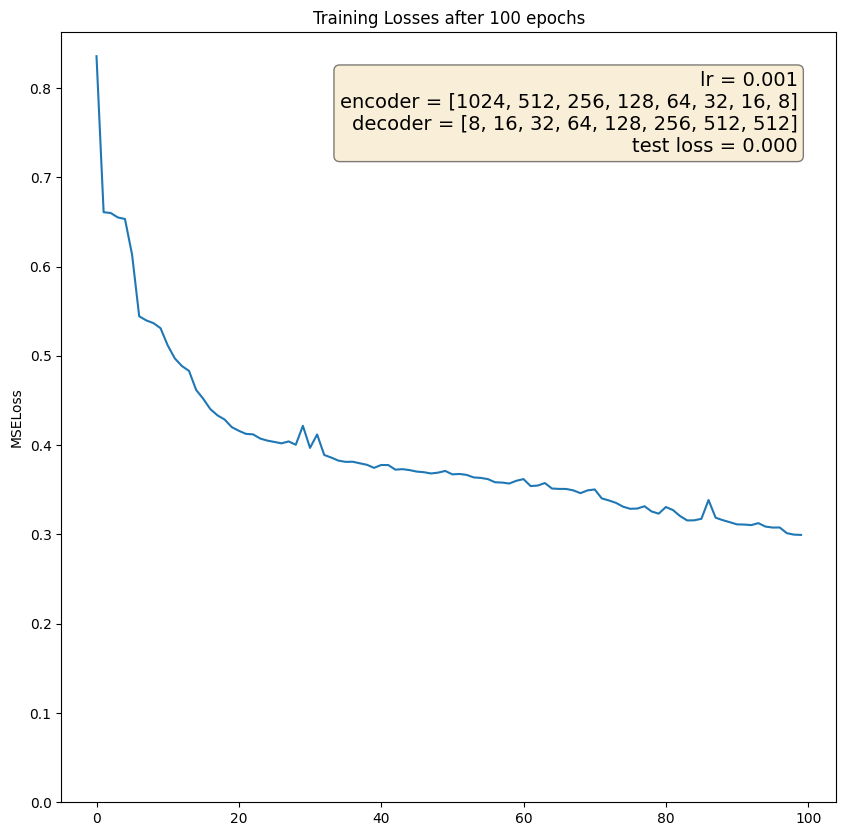

In [68]:
if launch_train_flag:
    model,losses = launch_train()
    plot_losses(losses,lr= lr,encoder= model.encoder_sizes,decoder= model.decoder_sizes,epochs= epochs,show = True,figs= '.',prefix= 'emb',test_loss= 0)
    torch.save(model.state_dict(), f"model_{time.strftime('%Y%m%d-%H%M%S')}.pkl")

## 5. Inference

Next, we will define the functions needed for inference, including a small gradio app to visualize outputs
![inference](assets/inference.png)

For instance, next theres an example of inputs and outputs
![model_output](assets/model_output.png)

In [69]:
def _get_inference_embedding(emb_file):
    inference_vectors = []
    with open(emb_file, "r") as f:
        reader = csv.reader(f, delimiter='|')
        for row in reader:
            configid = row[0]
            vectors = row[1:]
            vectors = [ast.literal_eval(vector) for vector in vectors]
            inference_vectors.append(torch.tensor(vectors, dtype=torch.float32))
        t_0 = inference_vectors[0]
        t_1 = inference_vectors[1]
        t = torch.stack((t_0,t_1))
        inference_input = t.view(-1, 2*MM_EMB_DIMS)
    return inference_input

def predict_item(model,inference_dir,dev,engine=None):
    #Clear dirs
    shutil.rmtree(os.path.join(EMBEDDINGS_DIR,INFERENCE_DIR),ignore_errors=True)
    #shutil.rmtree(os.path.join(CROPPED_DIR,INFERENCE_DIR),ignore_errors=True)
    #preprocess_images(inference_dir,OBJECT_CATEGORY,True)
    gen_embeddings(os.path.join(CROPPED_DIR,INFERENCE_DIR),True,LOCAL)
    outputs = []
    for incomplete_look in os.listdir(os.path.join(EMBEDDINGS_DIR,INFERENCE_DIR)):
        if not incomplete_look.startswith('.'):
            logging.info(f"Processing {incomplete_look}...")
            emb_file = os.path.join(EMBEDDINGS_DIR,INFERENCE_DIR,incomplete_look,EMB_FILE_NAME)
            inference_input = _get_inference_embedding(emb_file).to(dev)
            model.eval()
            output = model(inference_input)
            top_elements = search_closest(output,emb_kv_database,TOP_K,dev,engine)
            outputs.append(top_elements)
    return outputs

In [75]:
engine = 'chromadb'
if lanch_ui_predict:
        def predict(files):
            shutil.rmtree(os.path.join(CROPPED_DIR,INFERENCE_DIR),ignore_errors=True)
            Path(os.path.join(CROPPED_DIR,INFERENCE_DIR,"look")).mkdir(parents=True, exist_ok=True)
            for file in files:
                path = os.path.join(CROPPED_DIR,INFERENCE_DIR,"look",os.path.basename(file))
                shutil.copyfile(file.name, path)    
            top_elements = predict_item(model,INFERENCE_DIR,dev,engine)
            if engine == "chromadb":
                top_elements = top_elements[0]['ids'][0]
                logging.info(f"top_elements is {top_elements}")
                if dataset == "fashion_mnist":
                    pattern = re.compile(r'look_(\d+)-(\d+)')
                    logging.info(top_elements[0])
                    logging.info(top_elements[1])
                    logging.info(top_elements[2])
                    match_0_image = os.path.join(CROPPED_DIR,"look_"+pattern.match(top_elements[0]).group(1),pattern.match(top_elements[0]).group(2)+".png")
                    match_1_image = os.path.join(CROPPED_DIR,"look_"+pattern.match(top_elements[1]).group(1),pattern.match(top_elements[1]).group(2)+".png")
                    match_2_image = os.path.join(CROPPED_DIR,"look_"+pattern.match(top_elements[2]).group(1),pattern.match(top_elements[2]).group(2)+".png")
                elif dataset == "chictopia":
                    pattern = re.compile(r'(\d+)-([a-zA-Z_]+)\.png')
                    logging.info(top_elements[0])
                    logging.info(top_elements[1])
                    logging.info(top_elements[2])
                    match_0_image = os.path.join(CROPPED_DIR,pattern.match(top_elements[0]).group(1),pattern.match(top_elements[0]).group(2)+".png")
                    match_1_image = os.path.join(CROPPED_DIR,pattern.match(top_elements[1]).group(1),pattern.match(top_elements[1]).group(2)+".png")
                    match_2_image = os.path.join(CROPPED_DIR,pattern.match(top_elements[2]).group(1),pattern.match(top_elements[2]).group(2)+".png")
            return [Image.open(match_0_image),Image.open(match_1_image),Image.open(match_2_image)]

        demo = gr.Interface(
          fn=predict,
          inputs=gr.File(file_count="multiple", label=None),
          outputs=gr.Gallery(preview=True),
        )
        demo.launch(share=True) 

INFO:httpx:HTTP Request: GET http://127.0.0.1:7862/startup-events "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: HEAD http://127.0.0.1:7862/ "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.gradio.app/pkg-version "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.gradio.app/gradio-initiated-analytics/ "HTTP/1.1 200 OK"


Running on local URL:  http://127.0.0.1:7862


INFO:httpx:HTTP Request: GET https://api.gradio.app/v2/tunnel-request "HTTP/1.1 200 OK"


Running on public URL: https://e67bd7714ff92632f4.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


INFO:httpx:HTTP Request: HEAD https://e67bd7714ff92632f4.gradio.live "HTTP/1.1 200 OK"


INFO:httpx:HTTP Request: POST https://api.gradio.app/gradio-launched-telemetry/ "HTTP/1.1 200 OK"
Processing image sets:   0%|          | 0/1 [00:00<?, ?set/s]/opt/conda/envs/pytorch/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/envs/pytorch/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Processing image sets: 100%|██████████| 1/1 [00:00<00:00,  1.52set/s]
INFO:root:Processing look...
INFO:root:top_elements is ['look_134-0.png', 'look_166-0.png', 'look_53-0.png']
INFO:root:loo